In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.decomposition import TruncatedSVD
import pickle

In [2]:
df = pd.read_json('transactions.txt', lines=True)
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


In [3]:
ros = RandomUnderSampler()
y = df['isFraud']
df.drop(columns=['isFraud'], inplace=True)
X, y = ros.fit_resample(df, y)
df2 = pd.concat([X, y], axis=1)

In [4]:
df2.isFraud.value_counts()

isFraud
False    12417
True     12417
Name: count, dtype: int64

In [5]:
df2.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,927230788,927230788,5000,896.05,2016-03-25T21:35:36,3.54,AMC #692956,US,US,05,...,,4103.95,,,,True,,,False,False
1,604712015,604712015,15000,15000.00,2016-05-19T22:48:14,136.82,Lyft,US,US,05,...,,0.00,,,,False,,,False,False
2,801064879,801064879,2500,1047.76,2016-05-16T11:01:22,293.50,Boston Fries,US,US,09,...,,1452.24,,,,True,,,False,False
3,153920875,153920875,250,104.14,2016-03-31T17:10:21,127.28,Chicago News,US,US,05,...,,145.86,,,,False,,,False,False
4,204494014,204494014,2500,1476.72,2016-12-12T22:24:27,130.40,walmart.com,US,US,90,...,,1023.28,,,,False,,,False,False


In [6]:
def split_train_test(data, test_ratio, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [7]:
train_set, validation_set = split_train_test(df2, 0.2, random_state=1)
print(len(train_set))
print(len(validation_set))

19868
4966


In [109]:
print(train_set.shape)
print(X_train.shape)

(19868, 29)
(13907, 266)


In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataClean(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = SimpleImputer(strategy='most_frequent')
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        for col in X.columns:
            if any(X[col] == ''):
                X.loc[X[col] == '', col] = np.nan
            if X[col].dtype == bool:
                X.loc[:,col] = X[col].astype(int)
                
        X = X.drop(columns=['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd', 'customerId', 'accountNumber'])
                
        X['acqCountry'] = X.groupby('merchantCountryCode')['acqCountry'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x.iloc[0])
        missing_features = X.columns[X.isna().any()].tolist()
        # X[missing_features] = pd.DataFrame(self.imputer.fit_transform(X[missing_features]), columns=missing_features)
        X[missing_features] = self.imputer.fit_transform(X[missing_features])
        # X = pd.DataFrame(self.imputer.fit_transform(X), columns=X.columns)
        return X
    

In [9]:
dataclean = DataClean()
dataclean.fit_transform(train_set)

,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
5307,5000,2765.40,2016-01-21T07:06:32,15.17,Blue Mountain eCards,US,US,02,01,online_gifts,...,2014-06-21,2016-01-13,869,869,593,PURCHASE,2234.60,0,0,0
2131,1000,686.53,2016-11-26T07:24:18,105.46,Convenient Auto Services,US,US,02,01,auto,...,2011-08-01,2016-11-24,389,389,8601,PURCHASE,313.47,1,0,0
22434,15000,6829.48,2016-02-09T06:42:31,91.97,Boston Cafe #465229,US,US,09,01,food,...,2014-05-13,2014-05-13,432,432,8517,PURCHASE,8170.52,1,0,1
3141,50000,42526.83,2016-03-24T15:54:38,28.71,Washington Times,US,US,09,01,subscriptions,...,2010-08-14,2010-08-14,207,207,571,REVERSAL,7473.17,0,0,0
11701,10000,2006.91,2016-11-04T22:07:03,69.27,staples.com,US,US,05,01,online_retail,...,2012-05-21,2016-10-05,108,108,6836,PURCHASE,7993.09,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,5000,336.83,2016-12-06T12:06:29,44.38,Mobil Gas #851671,US,US,02,01,fuel,...,2013-10-31,2013-10-31,851,851,7109,PURCHASE,4663.17,1,0,0
17289,500,44.80,2016-06-27T13:09:43,84.53,Arbys #332223,US,US,05,01,fastfood,...,2014-12-11,2016-01-23,445,445,7948,PURCHASE,455.20,1,0,1
5192,5000,1076.96,2016-01-31T05:35:39,43.49,Fresh Flowers,US,US,02,01,online_gifts,...,2014-06-21,2016-01-29,869,869,593,PURCHASE,3923.04,0,0,0
12172,15000,11352.01,2016-02-07T12:19:01,89.41,Fresh Online Services,US,US,05,01,online_gifts,...,2013-01-22,2013-01-22,670,670,3118,PURCHASE,3647.99,0,0,0


In [14]:
class FeatureExtraction(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X['transactionDateTime'] = pd.to_datetime(X['transactionDateTime'], errors='coerce')
        X['accountOpenDate'] = pd.to_datetime(X['accountOpenDate'], errors='coerce')
        X['dateOfLastAddressChange'] = pd.to_datetime(X['dateOfLastAddressChange'], errors='coerce')
        X['currentExpDate'] = pd.to_datetime(X['currentExpDate'], errors='coerce', format='%m/%Y')
        
        X['trans_day_name'] = X.transactionDateTime.apply(lambda x: datetime.strftime(x, '%A'))
        X['trans_day_of_week'] = X.transactionDateTime.apply(lambda x: datetime.strftime(x, '%A'))
        X['trans_month'] = X.transactionDateTime.apply(lambda x: int(datetime.strftime(x, '%m')))
        X['trans_day_addr_change_diff'] = (X.transactionDateTime - X.dateOfLastAddressChange).dt.days
        X['trans_day_open_date_diff'] = (X.transactionDateTime - X.accountOpenDate).dt.days
        X['exp_month'] = X.currentExpDate.apply(lambda x:int(datetime.strftime(x, '%m')))
        X['exp_year'] = X.currentExpDate.apply(lambda x:int(datetime.strftime(x, '%Y')))
        X['matchingCVV'] = X.cardCVV == X.enteredCVV
        X['brandName'] = X['merchantName'].apply(lambda x: x.split('#')[0].strip())
        X = X.drop(columns=['merchantName','currentExpDate', 'transactionDateTime', 'accountOpenDate', 'dateOfLastAddressChange'])
        
        
        return X

In [24]:
feature_extraction = FeatureExtraction()
feature_extraction.fit_transform(train_set)

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,...,isFraud,trans_day_name,trans_day_of_week,trans_month,trans_day_addr_change_diff,trans_day_open_date_diff,exp_month,exp_year,matchingCVV,brandName
5307,380680241,380680241,5000,2765.40,15.17,US,US,02,01,online_gifts,...,False,Thursday,Thursday,1,8,579,10,2022,True,Blue Mountain eCards
2131,515727487,515727487,1000,686.53,105.46,US,US,02,01,auto,...,False,Saturday,Saturday,11,2,1944,2,2033,True,Convenient Auto Services
22434,415737579,415737579,15000,6829.48,91.97,US,US,09,01,food,...,True,Tuesday,Tuesday,2,637,637,10,2027,True,Boston Cafe
3141,574932949,574932949,50000,42526.83,28.71,US,US,09,01,subscriptions,...,False,Thursday,Thursday,3,2049,2049,3,2020,True,Washington Times
11701,469500742,469500742,10000,2006.91,69.27,US,US,05,01,online_retail,...,False,Friday,Friday,11,30,1628,6,2026,True,staples.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,773579767,773579767,5000,336.83,44.38,US,US,02,01,fuel,...,False,Tuesday,Tuesday,12,1132,1132,8,2028,True,Mobil Gas
17289,172230695,172230695,500,44.80,84.53,US,US,05,01,fastfood,...,True,Monday,Monday,6,156,564,10,2028,True,Arbys
5192,380680241,380680241,5000,1076.96,43.49,US,US,02,01,online_gifts,...,False,Sunday,Sunday,1,2,589,5,2031,True,Fresh Flowers
12172,476445691,476445691,15000,11352.01,89.41,US,US,05,01,online_gifts,...,False,Sunday,Sunday,2,1111,1111,4,2023,True,Fresh Online Services


In [25]:
num_cols = ['creditLimit',
 'availableMoney',
 'transactionAmount',
 'cardCVV',
 'enteredCVV',
 'cardLast4Digits',
 'currentBalance',
 'cardPresent',
 'expirationDateKeyInMatch',
 'trans_month',
 'trans_day_addr_change_diff',
 'trans_day_open_date_diff', 'exp_month', 'exp_year']

In [26]:
categorical_cols = ['brandName',
 'acqCountry',
 'merchantCountryCode',
 'posEntryMode',
 'posConditionCode',
 'merchantCategoryCode',
 'transactionType',
 'trans_day_name',
 'trans_day_of_week']

In [18]:
col_transformer = ColumnTransformer([('standard_scaler', StandardScaler(), num_cols),
                                    ('onehot_encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), categorical_cols)
                                   ])

In [27]:
all_pipeline = Pipeline([
    ('DataClean', DataClean()),
    ('FeatureExtraction', FeatureExtraction()),
    ('col_transformer', col_transformer)
])

In [28]:
all_pipeline.steps

[('DataClean', DataClean()),
 ('FeatureExtraction', FeatureExtraction()),
 ('col_transformer',
  ColumnTransformer(transformers=[('standard_scaler', StandardScaler(),
                                   ['creditLimit', 'availableMoney',
                                    'transactionAmount', 'cardCVV', 'enteredCVV',
                                    'cardLast4Digits', 'currentBalance',
                                    'cardPresent', 'expirationDateKeyInMatch',
                                    'trans_month', 'trans_day_addr_change_diff',
                                    'trans_day_open_date_diff', 'exp_month',
                                    'exp_year']),
                                  ('onehot_encoder',
                                   OneHotEncoder(drop='if_binary',
                                                 handle_unknown='ignore'),
                                   ['brandName', 'acqCountry',
                                    'merchantCountryCode', 'posE

In [29]:
X, y = train_set.drop('isFraud', axis=1), train_set['isFraud']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train = all_pipeline.fit_transform(X_train)
X_test = all_pipeline.transform(X_test)

/home/georgetz/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [23]:
print(X_train.shape)
print(X_test.shape)

(13907, 266)
(5961, 266)


In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [81]:
params = {
            'penalty': ['l2', 'elasticnet'],
            'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10, 100],
            'fit_intercept': [True, False],
            'solver': ['liblinear', 'saga']
        }
gridsearch = GridSearchCV(estimator=LogisticRegression(), param_grid=params, cv=5, verbose=0)

In [82]:
gridsearch.fit(X_train, y_train)

/home/georgetz/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/georgetz/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/georgetz/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/georgetz/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/georgetz/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/georgetz/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10, 100],
                         'fit_intercept': [True, False],
                         'penalty': ['l2', 'elasticnet'],
                         'solver': ['liblinear', 'saga']})

In [80]:
gridsearch.best_estimator_

LogisticRegression(C=0.5, solver='saga')

In [89]:
gridsearch.best_score_

0.696484127298028

In [91]:
cv_results = pd.DataFrame(gridsearch.cv_results_)
cv_results.sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_fit_intercept,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
45,0.401777,0.006680,0.001353,0.000244,0.5,False,l2,saga,"{'C': 0.5, 'fit_intercept': False, 'penalty': ...",0.687635,0.700575,0.706940,0.694714,0.692557,0.696484,0.006677,1
41,0.499497,0.028824,0.001767,0.000314,0.5,True,l2,saga,"{'C': 0.5, 'fit_intercept': True, 'penalty': '...",0.687275,0.700575,0.706940,0.695074,0.692197,0.696412,0.006800,2
37,0.490176,0.039715,0.001554,0.000216,0.1,False,l2,saga,"{'C': 0.1, 'fit_intercept': False, 'penalty': ...",0.691589,0.698418,0.705502,0.696152,0.690399,0.696412,0.005406,3
33,0.377983,0.024345,0.001174,0.000179,0.1,True,l2,saga,"{'C': 0.1, 'fit_intercept': True, 'penalty': '...",0.691589,0.698418,0.705142,0.696152,0.690399,0.696340,0.005286,4
49,0.415609,0.014322,0.001425,0.000326,1,True,l2,saga,"{'C': 1, 'fit_intercept': True, 'penalty': 'l2...",0.689792,0.698778,0.706580,0.696152,0.690040,0.696268,0.006219,5


In [73]:
with open('log_reg.pkl', 'wb') as file:
    pickle.dump(gridsearch.best_estimator_, file)

In [83]:
params = {
            'n_estimators': [10, 50, 100, 300, 500],
            'max_depth': [1, 3, 5],
            'bootstrap': [True, False],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'oob_score': [True, False]
        }

gridsearch = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params, cv=5)

gridsearch.fit(X_train, y_train)

/home/georgetz/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/georgetz/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/georgetz/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/georgetz/.local/lib/python3.8/site-packages/sklearn

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False], 'max_depth': [1, 3, 5],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 300, 500],
                         'oob_score': [True, False]})

In [84]:
gridsearch.best_estimator_

RandomForestClassifier(max_depth=5, max_features='auto', min_samples_leaf=4,
                       oob_score=True)

In [85]:
gridsearch.best_score_

0.6977058043295228

In [86]:
with open('random_forest.pkl', 'wb') as file:
    pickle.dump(gridsearch.best_estimator_, file)

In [31]:
from sklearn.cluster import KMeans
kmeans = KMeans()

In [50]:
total_explained_variance_ratio = []
n_values = range(2,21)
for ni in n_values:
    svd = TruncatedSVD(n_components=ni)
    X_svd = svd.fit(X_train)
    total_explained_variance_ratio.append(np.sum(svd.explained_variance_ratio_))

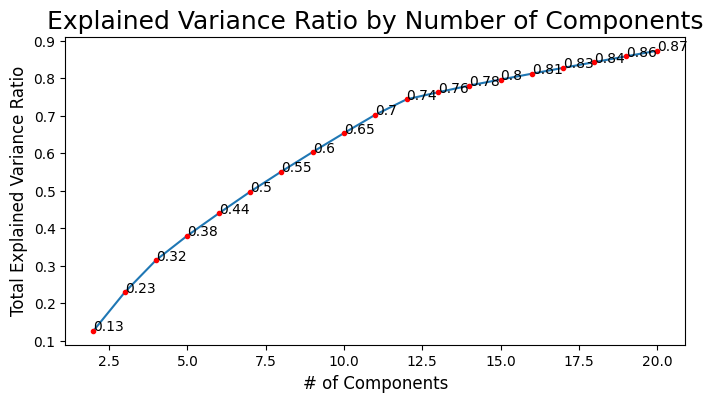

In [110]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(n_values, total_explained_variance_ratio)
ax.set_title('Explained Variance Ratio by Number of Components', fontsize=18)
ax.set_xlabel('# of Components', fontsize=12)
ax.set_ylabel('Total Explained Variance Ratio', fontsize=12)
for ni, vi in zip(n_values, total_explained_variance_ratio):
    ax.plot(ni,vi, '.', color='red')
    ax.text(ni, vi, np.round(vi, 2))

In [111]:
# fig.savefig('explained_variance_ratio.png')

In [112]:
svd = TruncatedSVD(n_components=12)
X_svd = pd.DataFrame(svd.fit_transform(X_train))
X_svd

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.838270,3.288929,3.794622,0.440977,1.254164,-0.313197,-0.185510,-0.524578,0.602864,0.623633,-2.288074,0.052004
1,2.076036,-0.638414,-1.099704,1.107065,0.820601,0.574517,-0.359675,-0.128187,0.734394,-1.495276,0.744009,0.738306
2,2.088538,-0.876971,-1.461383,-0.383942,-0.527831,1.028005,-0.155519,-0.775354,0.433610,0.923510,0.075202,0.621458
3,2.101009,-2.053982,1.414377,-1.397631,0.508367,1.637728,-0.782541,-0.193390,0.730556,-0.772022,-0.459245,0.374523
4,2.107838,-1.206016,1.053130,-0.357307,-0.021484,0.726796,1.039341,0.846058,0.241022,-2.602624,0.450471,0.775144
...,...,...,...,...,...,...,...,...,...,...,...,...
13902,2.189707,0.286293,-2.183577,-0.595720,-0.546536,0.240339,-1.193537,-0.374077,0.742191,0.571276,-0.571771,0.395213
13903,2.178491,1.242340,-0.659552,-0.222939,0.334789,-1.543217,-0.445578,-0.152355,-0.068962,0.487193,0.902648,0.154921
13904,2.092765,-1.686603,1.902238,1.503268,0.372618,-0.334592,0.739517,1.366819,-0.773168,-2.640460,0.570260,-0.947143
13905,2.066617,-2.059884,1.084600,-0.691346,-0.483683,0.447620,-1.542630,-0.187094,0.233980,0.329672,0.883693,0.010959


In [114]:
np.sum(svd.explained_variance_ratio_)

0.7433119621187775

In [119]:
inertia = []

# Try different values of k (number of clusters)
k_values = range(1, 16)
for k in k_values:
    # Create a KMeans instance with current k value
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(X_svd)
    
    # Append the inertia value to the list
    inertia.append(kmeans.inertia_)

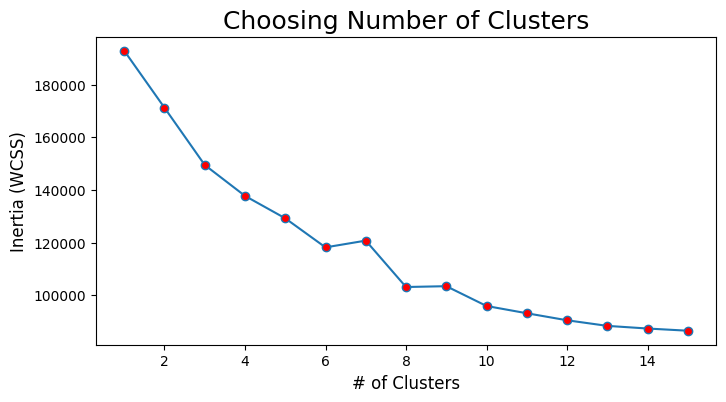

In [120]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(k_values, inertia, marker='o', mfc='red')
ax.set_title('Choosing Number of Clusters', fontsize=18)
ax.set_xlabel('# of Clusters', fontsize=12)
ax.set_ylabel('Inertia (WCSS)', fontsize=12)
plt.show()

In [121]:
# fig.savefig('kmeans_inertia.png')

In [122]:
kmeans = KMeans(n_clusters=4, n_init='auto')
kmeans.fit(X_svd)

KMeans(n_clusters=4, n_init='auto')

In [123]:
kmeans.inertia_

140216.70782258018

In [134]:
data = pd.Series(kmeans.labels_)
data.name = 'label'
data

0        2
1        0
2        1
3        0
4        0
        ..
13902    1
13903    1
13904    0
13905    3
13906    3
Name: label, Length: 13907, dtype: int32

,0,1,2,3,4,5,6,7,8,9,10,11,label
0,1.838270,3.288929,3.794622,0.440977,1.254164,-0.313197,-0.185510,-0.524578,0.602864,0.623633,-2.288074,0.052004,2
1,2.076036,-0.638414,-1.099704,1.107065,0.820601,0.574517,-0.359675,-0.128187,0.734394,-1.495276,0.744009,0.738306,0
2,2.088538,-0.876971,-1.461383,-0.383942,-0.527831,1.028005,-0.155519,-0.775354,0.433610,0.923510,0.075202,0.621458,1
3,2.101009,-2.053982,1.414377,-1.397631,0.508367,1.637728,-0.782541,-0.193390,0.730556,-0.772022,-0.459245,0.374523,0
4,2.107838,-1.206016,1.053130,-0.357307,-0.021484,0.726796,1.039341,0.846058,0.241022,-2.602624,0.450471,0.775144,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13902,2.189707,0.286293,-2.183577,-0.595720,-0.546536,0.240339,-1.193537,-0.374077,0.742191,0.571276,-0.571771,0.395213,1
13903,2.178491,1.242340,-0.659552,-0.222939,0.334789,-1.543217,-0.445578,-0.152355,-0.068962,0.487193,0.902648,0.154921,1
13904,2.092765,-1.686603,1.902238,1.503268,0.372618,-0.334592,0.739517,1.366819,-0.773168,-2.640460,0.570260,-0.947143,0
13905,2.066617,-2.059884,1.084600,-0.691346,-0.483683,0.447620,-1.542630,-0.187094,0.233980,0.329672,0.883693,0.010959,3


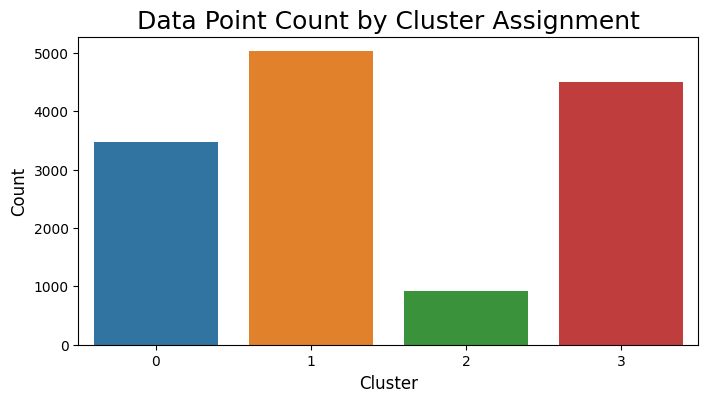

In [140]:
data = pd.concat([X_svd, pd.Series(kmeans.labels_, name='label')], axis=1)
fig, ax = plt.subplots(figsize=(8,4))
sns.countplot(data=data, x='label', ax=ax)
ax.set_title('Data Point Count by Cluster Assignment', fontsize=18)
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.show()

In [142]:
# fig.savefig('count_by_cluster.png')

In [ ]:
pd.Series(kmeans.labels_).value_counts()

In [71]:
kmeans.inertia_

140219.6267296428

<Axes: xlabel='1', ylabel='2'>

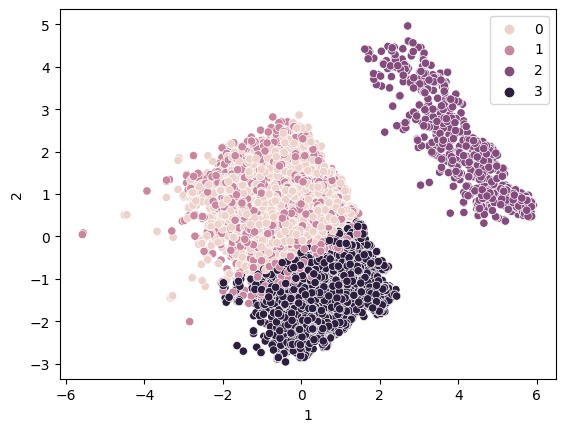

In [69]:
sns.scatterplot(data=X_svd, x=1, y=2, hue=kmeans.labels_)

In [20]:
inertia = []

# Try different values of k (number of clusters)
k_values = range(1, 16)
for k in k_values:
    # Create a KMeans instance with current k value
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train)
    
    # Append the inertia value to the list
    inertia.append(kmeans.inertia_)


/home/georgetz/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


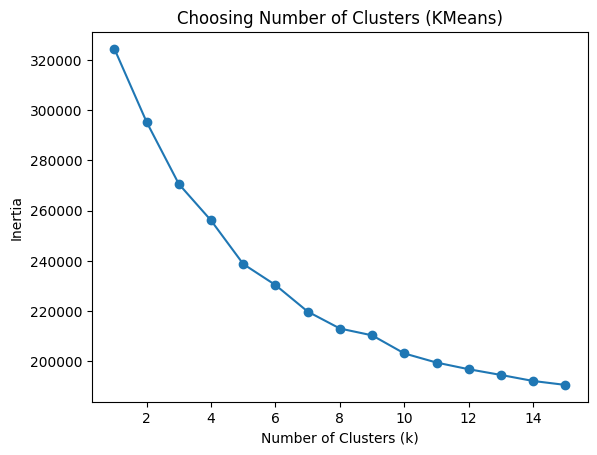

In [21]:
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Choosing Number of Clusters (KMeans)')
plt.savefig('kmeans_clusters.png')
plt.show()

In [148]:
kmeans = KMeans(n_clusters=4)
distances = kmeans.fit_transform(X_train)
labels = kmeans.labels_

/home/georgetz/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


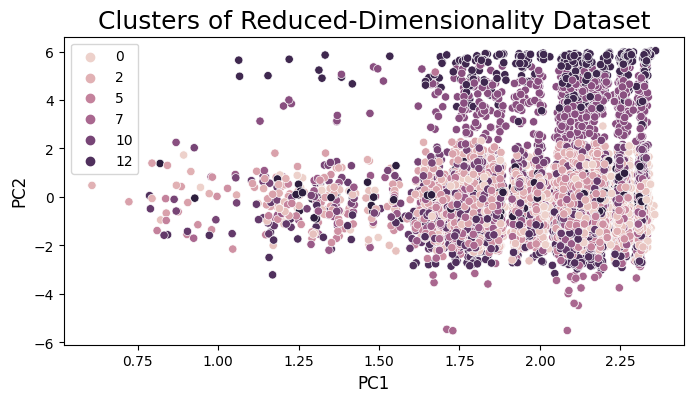

In [22]:
svd = TruncatedSVD(n_components=2)
X_svd = pd.DataFrame(svd.fit_transform(X_train))
X_svd['label'] = kmeans.labels_
fig, ax = plt.subplots(figsize=(8,4))
sns.scatterplot(data=X_svd, x=0, y=1, hue='label')
ax.set_title('Clusters of Reduced-Dimensionality Dataset', fontsize=18)
ax.legend()
ax.set_xlabel('PC1', fontsize=12)
ax.set_ylabel('PC2', fontsize=12)
plt.show()

In [146]:
fig.savefig('kmeans_viz.png')

In [23]:
svd.explained_variance_ratio_

array([0.00225434, 0.12353072])